In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix, classification_report
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 =

In [2]:
audio_df=pd.read_csv('audio.csv',usecols=['emotion','path'])

In [3]:
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

In [4]:
audio_df

,emotion,path
0,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
1,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
2,angry,/Users/murielkosaka/Desktop/capstone_project/a...
3,fear,/Users/murielkosaka/Desktop/capstone_project/a...
4,fear,/Users/murielkosaka/Desktop/capstone_project/a...
...,...,...
1435,fear,/Users/murielkosaka/Desktop/capstone_project/a...
1436,fear,/Users/murielkosaka/Desktop/capstone_project/a...
1437,angry,/Users/murielkosaka/Desktop/capstone_project/a...
1438,surprise,/Users/murielkosaka/Desktop/capstone_project/a...


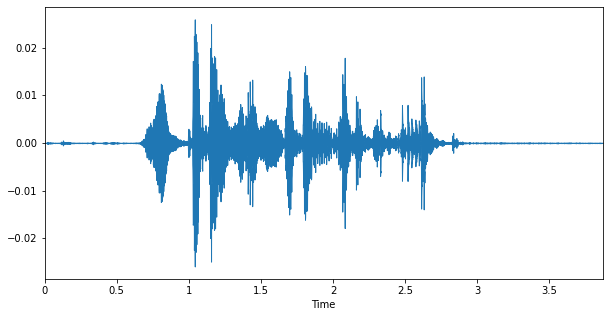

In [5]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)



In [6]:
def noise(x):
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   # more noise reduce the value to 0.5
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

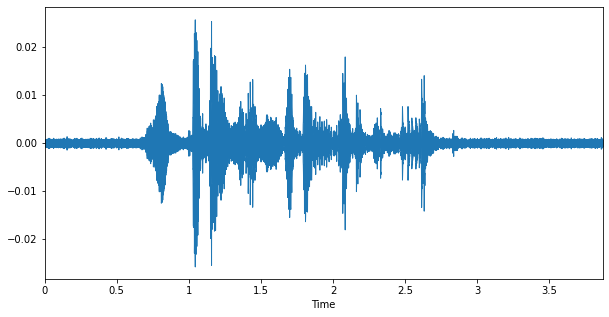

In [7]:
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [8]:
def stretch(x, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(x, rate)
    return data

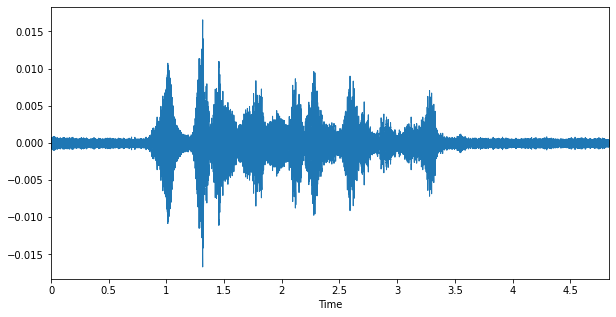

In [9]:
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [10]:
def speedNpitch(x):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

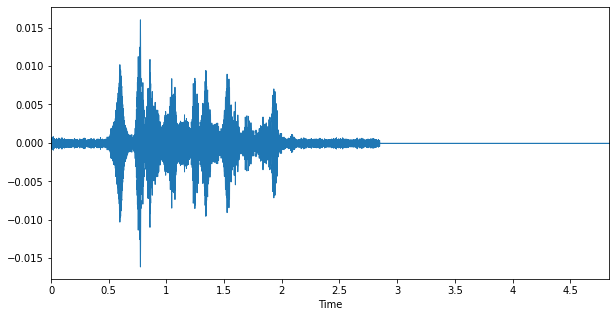

In [11]:
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

In [12]:
df = pd.DataFrame(columns=['log_spec'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
df_stretch=pd.DataFrame(columns=['feature'])
counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   

    # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug]  
    
    # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug]  

    counter += 1
     

print(len(df))
df.head()

1440


,log_spec
0,"[-71.20022, -71.20022, -71.20022, -71.20022, -..."
1,"[-70.46105, -70.46105, -70.46105, -70.46105, -..."
2,"[-64.17679, -64.39374, -64.444954, -64.26804, ..."
3,"[-73.2803, -73.2803, -73.2803, -73.2803, -73.2..."
4,"[-44.965843, -44.467876, -44.512608, -44.93480..."


In [13]:
spec_df = pd.DataFrame(df['log_spec'].values.tolist())
labels = audio_df.emotion
spec = pd.concat([spec_df,labels], axis=1)
spec = spec.rename(index=str, columns={"0": "label"})

In [14]:
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={"0": "label"})

In [15]:
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={"0": "label"})

In [16]:
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={"0": "label"})

In [17]:
combined_df = pd.concat([spec, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,surprise
1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
2,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,-64.468147,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941,angry
3,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,...,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915,fear
4,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,-46.124241,-45.938686,-46.116108,...,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274,fear


## CNN

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

Using TensorFlow backend.


In [19]:
# TRAIN TEST SPLIT
X_model, X_test, y_model, y_test = train_test_split(combined_df.drop(['emotion'],axis=1)
                                                    , combined_df.emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = combined_df.emotion
                                                   )
# TRAIN TEST SPLIT TO CREATE VALIDATION AND TRAINING SET
X_train, X_validation, y_train, y_validation = train_test_split(X_model
                                                    , y_model
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = y_model
                                                   )



In [20]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_validation = (X_validation - mean) / std



In [21]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation=np.array(X_validation)
y_validation=np.array(y_validation)

In [22]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
y_validation = to_categorical(lb.fit_transform(y_validation))


print(y_validation[0:10])

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [23]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [24]:
print(y_validation[0:10])

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [55]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

X_train.shape

(4608, 259, 1, 1)

In [26]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import SGD
from keras.constraints import max_norm
from keras.regularizers import l2


# acc-51,test acc-48
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
# model.add(Conv1D(256, kernel_size=(4), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001) 

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
___________________________________________________________

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_aug = ModelCheckpoint(filepath='best_model_aug.h5', monitor='val_accuracy', save_best_only=True)
# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=50, validation_data=(X_validation, y_validation),callbacks=[cb_aug])

Train on 3240 samples, validate on 1080 samples
Epoch 1/50
3240/3240 [==============================] - 11s 3ms/step - loss: 2.6596 - acc: 0.2373 - val_loss: 2.4373 - val_acc: 0.2815
Epoch 2/50
3240/3240 [==============================] - 12s 4ms/step - loss: 2.3332 - acc: 0.3000 - val_loss: 2.2379 - val_acc: 0.2870
Epoch 3/50
3240/3240 [==============================] - 11s 3ms/step - loss: 2.1851 - acc: 0.3111 - val_loss: 2.1141 - val_acc: 0.3065
Epoch 4/50
3240/3240 [==============================] - 10s 3ms/step - loss: 2.0615 - acc: 0.3275 - val_loss: 2.0180 - val_acc: 0.3000
Epoch 5/50
3240/3240 [==============================] - 11s 3ms/step - loss: 1.9720 - acc: 0.3404 - val_loss: 1.9484 - val_acc: 0.3185
Epoch 6/50
3240/3240 [==============================] - 11s 4ms/step - loss: 1.9027 - acc: 0.3426 - val_loss: 1.8854 - val_acc: 0.3278
Epoch 7/50
3240/3240 [==============================] - 11s 3ms/step - loss: 1.8459 - acc: 0.3639 - val_loss: 1.8364 - val_acc: 0.3407
Epoch 8

In [28]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1440/1440 [==============================] - 1s 1ms/step
Loss of the model is -  1.1435194359885321
1440/1440 [==============================] - 1s 892us/step
Accuracy of the model is -  59.93055555555556 %


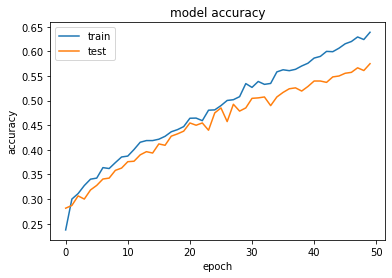

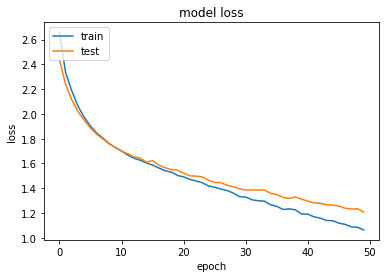

In [29]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
actual=y_test.argmax(axis=1)

In [31]:
lb.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)

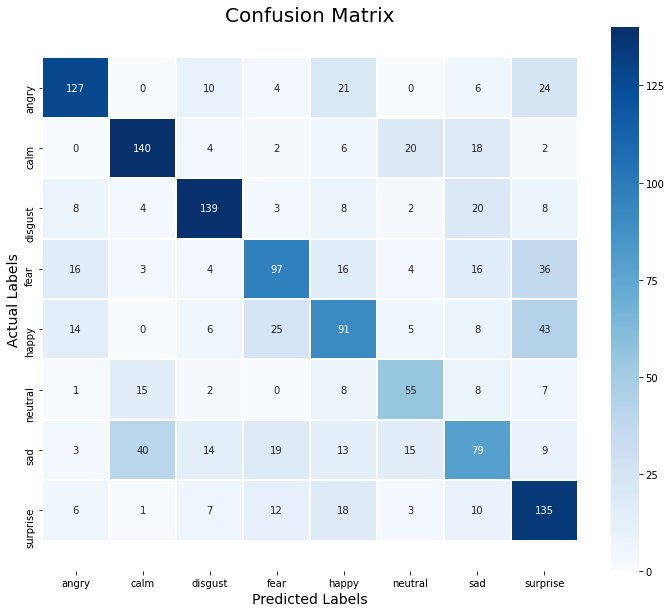

In [32]:
import seaborn as sns

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
# predictions 
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,surprise,surprise
141,happy,fear
142,angry,angry
143,surprise,surprise
144,happy,happy
145,surprise,surprise
146,happy,surprise
147,surprise,surprise
148,neutral,calm
149,surprise,surprise


In [34]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,surprise
1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
2,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,-64.468147,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941,angry
3,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,...,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915,fear
4,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,-46.124241,-45.938686,-46.116108,...,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274,fear


In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

#  Stratified Shuffle Split

X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [39]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [40]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [41]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


print(y_test[0:10])

[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [42]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [45]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_test.shape

(1152, 259, 1)

In [46]:
# acc-51,test acc-48
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
# model.add(Conv1D(256, kernel_size=(4), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 128)            0         
__________

In [49]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_aug = ModelCheckpoint(filepath='best_model_aug.h5', monitor='val_accuracy', save_best_only=True)
# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test),callbacks=[cb_aug])

Train on 4608 samples, validate on 1152 samples
Epoch 1/100
4608/4608 [==============================] - 16s 3ms/step - loss: 1.1382 - acc: 0.5931 - val_loss: 1.1402 - val_acc: 0.6050
Epoch 2/100
4608/4608 [==============================] - 14s 3ms/step - loss: 1.0213 - acc: 0.6404 - val_loss: 1.0683 - val_acc: 0.6484
Epoch 3/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.9613 - acc: 0.6736 - val_loss: 1.0630 - val_acc: 0.6476
Epoch 4/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.9348 - acc: 0.6760 - val_loss: 1.0281 - val_acc: 0.6606
Epoch 5/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.9126 - acc: 0.6860 - val_loss: 1.0047 - val_acc: 0.6866
Epoch 6/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.8871 - acc: 0.6912 - val_loss: 1.0127 - val_acc: 0.6632
Epoch 7/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.8682 - acc: 0.7105 - val_loss: 0.9960 - val_acc: 0.6823


4608/4608 [==============================] - 16s 3ms/step - loss: 0.4528 - acc: 0.8715 - val_loss: 0.6601 - val_acc: 0.8290
Epoch 61/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.4434 - acc: 0.8687 - val_loss: 0.6627 - val_acc: 0.8220
Epoch 62/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.4450 - acc: 0.8683 - val_loss: 0.6397 - val_acc: 0.8333
Epoch 63/100
4608/4608 [==============================] - 16s 3ms/step - loss: 0.4534 - acc: 0.8631 - val_loss: 0.6303 - val_acc: 0.8368
Epoch 64/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.4268 - acc: 0.8717 - val_loss: 0.6328 - val_acc: 0.8316
Epoch 65/100
4608/4608 [==============================] - 15s 3ms/step - loss: 0.4393 - acc: 0.8774 - val_loss: 0.6503 - val_acc: 0.8351
Epoch 66/100
4608/4608 [==============================] - 14s 3ms/step - loss: 0.4440 - acc: 0.8661 - val_loss: 0.6256 - val_acc: 0.8411
Epoch 67/100
4608/4608 [==============================

In [50]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1152/1152 [==============================] - 1s 1ms/step
Loss of the model is -  0.5457150091727575
1152/1152 [==============================] - 1s 1ms/step
Accuracy of the model is -  86.89236111111111 %


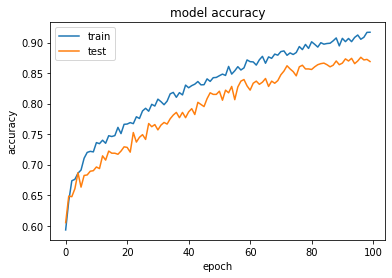

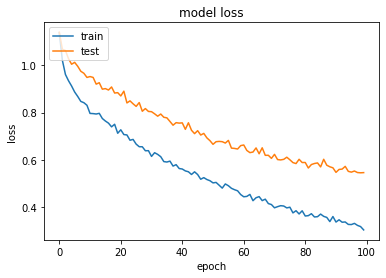

In [51]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
actual=y_test.argmax(axis=1)

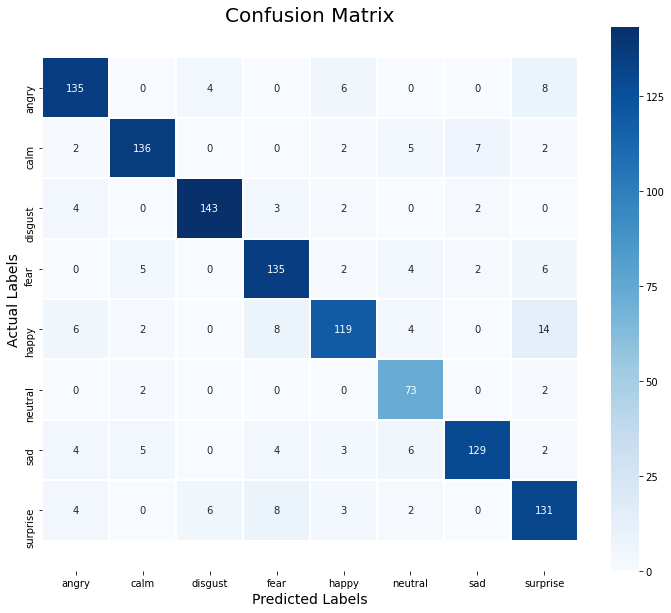

In [53]:
import seaborn as sns

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [54]:
# predictions 
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,happy,happy
141,fear,fear
142,happy,surprise
143,fear,fear
144,neutral,calm
145,calm,calm
146,fear,fear
147,neutral,neutral
148,happy,surprise
149,happy,fear
